# Creating an Encoder Decoder Network using CNN as the building block for portrait segmentation


As we are working with image data, CNN is the best option as it can learn/capture the spatial relations between the pixels. As the task in our hand is image segmentation (both input and output are images) we choose to build an Encoder Decoder network in such a way that the input and outut shapes are same(same resolution but segmented as a mask). Another Reason to choose such a network is that while encoding  the image into multiple feature maps it captures the semantic relations(i.e "What" is in the image) between the pixels and while decoding, the network captures the spatial relations("Where" it is in the image) between the pixels because for a segmentation task rather than just knowing what is the image we also must know where it is in the image.

The way it is different from other segmentation task is that we are dealing with portrait images and the main object of the image(Human face) has to be segmented precisely.

For our task we have taken a commonly used segmentation network called FCN8 and modified it according to our job specification.

Rather than using RGB channels only we first created another two channels naming Normalized XY channel and Shape channels whose details are provided along with their functions.

These two channels help in centralising the face in the image as well as provides a cannonical output shape for a better segmentation Result.

# Importing the libraries

In [1]:
import numpy as np #for numerical computations
import os #for handling operating system related tasks
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import * #for different types of hidden and output layer
from keras.optimizers import * #importing different keras optimizer functions
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as Kb
from keras.layers import Concatenate, concatenate
import tensorflow as tf

C:\Users\hp\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Creating a cropping function to convert the images into same shape

In [2]:
def crop( o1 , o2 , i  ):
    o_shape2 = Model( i  , o2 ).output_shape
    outputHeight2 = o_shape2[2] #height of the second image
    outputWidth2 = o_shape2[3] #height of the second image

    o_shape1 = Model( i  , o1 ).output_shape
    outputHeight1 = o_shape1[2] #height of the first image
    outputWidth1 = o_shape1[3] #width of the first image

    cx = abs( outputWidth1 - outputWidth2 ) #Difference between the widths of the two images
    cy = abs( outputHeight2 - outputHeight1 ) #Difference between the heights of the two images

    #Croping into same shape
    if outputWidth1 > outputWidth2:
        o1 = Cropping2D( cropping=((0,0) ,  (  0 , cx )) ,data_format=IMAGE_ORDERING  )(o1) 
    else:
        o2 = Cropping2D( cropping=((0,0) ,  (  0 , cx )),data_format=IMAGE_ORDERING  )(o2)
    
    if outputHeight1 > outputHeight2 :
        o1 = Cropping2D( cropping=((0,cy) ,  (  0 , 0 )),data_format=IMAGE_ORDERING  )(o1)
    else:
        o2 = Cropping2D( cropping=((0, cy ) ,  (  0 , 0 )) ,data_format=IMAGE_ORDERING  )(o2)

    return o1 , o2 #returns cropped images of same shape

# Creating our portraitFCN model

In [3]:
NUM_OF_CLASSESS = 2 #Background and foreground
IMAGE_WIDTH = 600 #input image width
IMAGE_HEIGHT = 800 #input image width
CHANNELS = 5 #RGB channels+shapechannel+normalizeed x-y channel
IMAGE_ORDERING = 'channels_first' #(channels,height,width) format

#creating the validation matrix
smooth=1
def dice_coef(y_true, y_pred):
    y_true_f = Kb.flatten(y_true)
    y_pred_f = Kb.flatten(y_pred)
    intersection = Kb.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (Kb.sum(y_true_f*y_true_f) + Kb.sum(y_pred_f*y_pred_f) + smooth)


#PortraitFCN

def PortraitFCN(nClasses = NUM_OF_CLASSESS,input_size = (CHANNELS,IMAGE_HEIGHT,IMAGE_WIDTH)):
    img_input = Input(input_size) #taking input to the model
    
    #Encoder Network
    
    #Block 1
    #64 (3,3) filters with Relu activation 
    conv1_1 = Conv2D(64,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(img_input) 
    #conv1_2 = tf.pad(conv1_1, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #64 (3,3) filters with Relu activation
    conv1_2 = Conv2D(64,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(conv1_1)
    #(2,2) maxpooling to extract most prominant features reducing the dimension
    pool1 = MaxPooling2D(pool_size=(2,2), data_format=IMAGE_ORDERING)(conv1_2)
        
    #Block 2
    #conv2_1 = tf.pad(pool1, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #128 (3,3) filters with Relu activation
    conv2_1 = Conv2D(128,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(pool1)
    #conv2_2 = tf.pad(conv2_1, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #128 (3,3) filters with Relu activation
    conv2_2 = Conv2D(128,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2,2), data_format=IMAGE_ORDERING)(conv2_2)

    #Block 3
    #conv3_1 = tf.pad(pool2, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #256 (3,3) filters with Relu activation
    conv3_1 = Conv2D(256,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(pool2)
    #conv3_2 = tf.pad(conv3_1, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #256 (3,3) filters with Relu activation
    conv3_2 = Conv2D(256,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(conv3_1)
    #conv3_3 = tf.pad(conv3_2, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #256 (3,3) filters with Relu activation
    conv3_3 = Conv2D(256,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(conv3_2)
    pool3 = MaxPooling2D(pool_size=(2,2), data_format=IMAGE_ORDERING)(conv3_3)
        
    #Block 4
    #conv4_1 = tf.pad(pool3, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #512 (3,3) filters with Relu activation
    conv4_1 = Conv2D(512,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(pool3)
    #conv4_2 = tf.pad(conv4_1, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #512 (3,3) filters with Relu activation
    conv4_2 = Conv2D(512,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(conv4_1)
    #conv4_3 = tf.pad(conv4_2, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #512 (3,3) filters with Relu activation
    conv4_3 = Conv2D(512,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(conv4_2)
    pool4 = MaxPooling2D(pool_size=(2,2), data_format=IMAGE_ORDERING)(conv4_3)
        
        
    #Block 5
    #conv5_1 = tf.pad(pool3, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #512 (3,3) filters with Relu activation
    conv5_1 = Conv2D(512,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(pool4)
    #conv5_2 = tf.pad(conv5_1, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #512 (3,3) filters with Relu activation
    conv5_2 = Conv2D(512,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(conv5_1)
    #conv5_3 = tf.pad(conv5_2, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
    #512 (3,3) filters with Relu activation
    conv5_3 = Conv2D(512,3,padding="same",activation='relu',data_format=IMAGE_ORDERING )(conv5_2)
    pool5 = MaxPooling2D(pool_size=(2,2), data_format=IMAGE_ORDERING)(conv5_3)
        
    #net = dict()
    #net['conv5_3'] = conv5_3
    #net['pool4'] = pool4
    #net['pool3'] = pool3
    #return net
        
    #flatten = Flatten()(pool5)
    #conv6 = Dense(4096,activation='relu')(flatten)
    #conv7 = Dense(4096,activation='relu')(fc1)
    #conv8 = Dense(NUM_OF_CLASSESS)
        
    conv6 = Conv2D( 4096 , 7 , activation='relu' , padding='same',data_format=IMAGE_ORDERING )(pool5)
    conv6_1 = Dropout(0.5)(conv6)
    conv7 = Conv2D( 4096 , 1 , activation='relu' , padding='same',data_format=IMAGE_ORDERING )(conv6_1)
    conv7_1 = Dropout(0.5)(conv7)
    conv8 = Conv2D(NUM_OF_CLASSESS, 1,kernel_initializer='he_normal',data_format=IMAGE_ORDERING )(conv7_1)
    
    
    #DECODER NETWORK
    
    #Block 1
    #(4,4)transpose convolution of stride 2 for upsampling
    convt_1 = Conv2DTranspose( NUM_OF_CLASSESS , 4 ,  strides=(2,2) , padding = 'same',data_format=IMAGE_ORDERING )(conv8)
    #(1,1) convolution for reducing dimensionalty
    C_pool4 = Conv2D( NUM_OF_CLASSESS ,  1 ,kernel_initializer='he_normal', data_format=IMAGE_ORDERING )(pool4)
    # making convt_1 and C_pool4 are of same shape
    convt_1,C_pool4 = crop(convt_1, C_pool4, img_input)
    #Concatinating featuremaps of upsampling and downsampling network
    fuse_1 = Add()([convt_1,C_pool4])
    
    #Block 2
    #(4,4)transpose convolution of stride 2 for upsampling
    convt_2 = Conv2DTranspose( NUM_OF_CLASSESS , 4 ,  strides=(2,2) , padding = 'same',data_format=IMAGE_ORDERING )(fuse_1)
    #(1,1) convolution for reducing dimensionalty
    C_pool3 = Conv2D( NUM_OF_CLASSESS ,  1 ,kernel_initializer='he_normal',data_format=IMAGE_ORDERING  )(pool3)
    # making convt_2 and C_pool3 are of same shape
    convt_2,C_pool3 = crop(convt_2, C_pool3, img_input)
    #Concatinating featuremaps of upsampling and downsampling network
    fuse_2 = Add()([convt_2,C_pool3])
    
    #(4,4)transpose convolution of stride 2 for upsampling
    convt_3 = Conv2DTranspose( NUM_OF_CLASSESS , 16 ,  strides=(8,8) , padding = 'same',data_format=IMAGE_ORDERING )(fuse_2)
    output = Activation('softmax')(convt_3)
    model = Model( img_input , output )
    
    #o_shape = Model(img_input , convt_3 ).output_shape

    #outputHeight = o_shape[2]
    #outputWidth = o_shape[3]

    #o = (Reshape((  -1  , outputHeight*outputWidth   )))(convt_3)
    #o = (Permute((2, 1)))(o)
    #o = (Activation('softmax'))(convt_3) #Applying Softmax to the outermost layer to make the prediction
    #model = Model( img_input , o )
    #model.outputWidth = outputWidth
    #model.outputHeight = outputHeight
        
    #model = Model(inputs = img_input, outputs = output)
    #model.outputWidth = outputWidth
    #model.outputHeight = outputHeight
    #adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

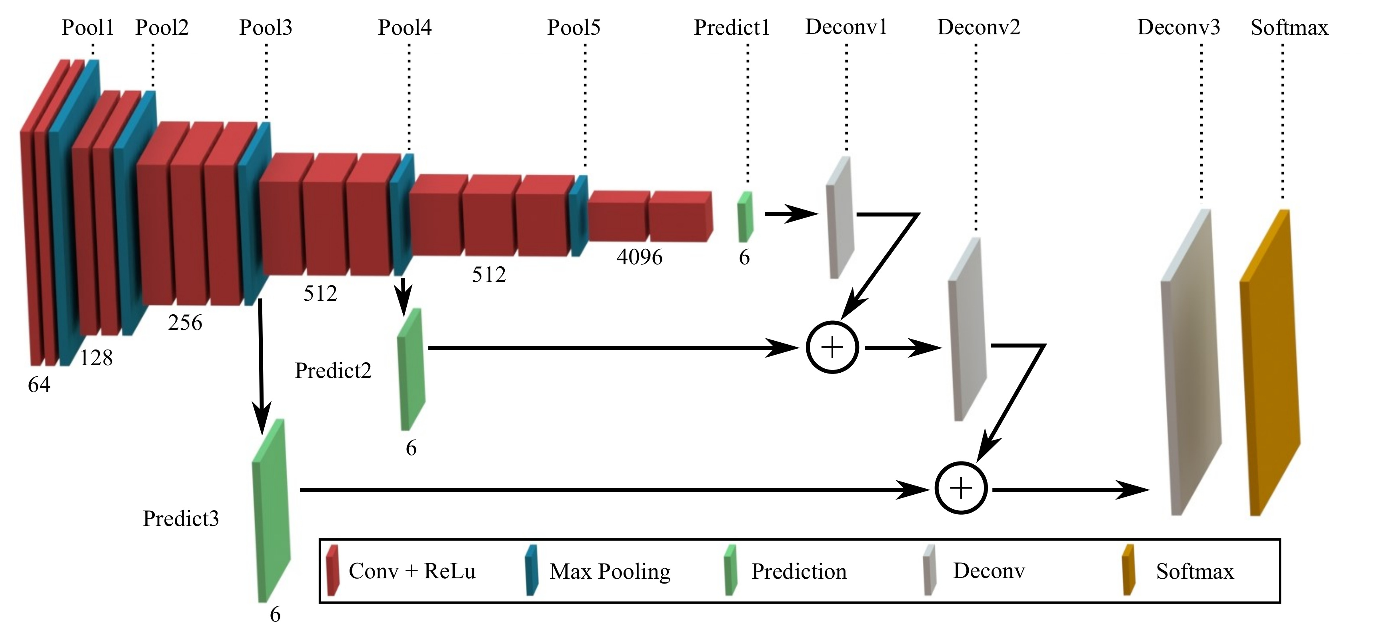

In [4]:
from IPython.display import Image
Image("fcn_arch_vgg16.png")

This is the basi FCN8 structure that I have followed to creat my model. The basic difference between this and our model is that here the predict layer is of 6 channels and ours is of 2 as it is a binary classification problem(we have to predict the mask).Also our input is a 5 channel input(RGB+Normalised x-y and shape channels).  